In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [33]:
work_data = pd.read_csv(r"E:\课题\2023暑期科研\data-algo\work_data.csv")
# 删除列
work_data = work_data.iloc[:, 1:]

# 将分类重新编码为1到16
lgbm_data = work_data.drop(columns=["名称", "日期"])
lgbm_data["分类"] = pd.factorize(lgbm_data["分类"])[0] + 1
lgbm_data["sentimentlevel"] = pd.factorize(lgbm_data["sentimentlevel"])[0] + 1

print(lgbm_data.head())

   分类         热度  上榜时间  levelnchar  sentimentlevel
0   1  3469652.0   203           2               1
1   2  3396691.0    69           5               2
2   3  3365924.0    42           3               1
3   1  3362505.0   167           1               3
4   4  3159712.0    28           3               1


In [34]:
X = lgbm_data.drop(columns=['热度'])
y = lgbm_data['热度']  # 目标

# 热度划分等级
threshold_low = np.quantile(y, 0.15)
print(threshold_low)
threshold_high = np.mean(y)
print(threshold_high)

y = np.where(y < threshold_low, 'low', np.where(y > threshold_high, 'high', 'medium'))
encoder = LabelEncoder()
labels = encoder.fit_transform(y)

174719.8
673648.6043193518


In [36]:
# 数据归一化 (使用Z-score标准化)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=999)
print(X_train)

[[-0.62868231  1.56453792  0.89603681 -1.48289591]
 [ 0.16481785  1.37449845 -0.11962332  1.24647353]
 [-0.62868231  1.1030135  -0.11962332 -1.48289591]
 ...
 [-0.62868231 -0.60734172  0.89603681 -0.11821119]
 [ 2.28081829 -0.85710787 -1.13528345 -1.48289591]
 [ 0.95831802 -0.21097368 -2.15094358  1.24647353]]


In [50]:
# 使用LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt'
}


In [51]:
bst = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=50)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 252371, number of used features: 4
[LightGBM] [Info] Start training from score -1.314235
[LightGBM] [Info] Start training from score -1.897031
[LightGBM] [Info] Start training from score -0.542476


In [52]:
preds = bst.predict(X_test)

In [53]:
pred_labels = encoder.inverse_transform(np.argmax(preds, axis=1))
y_test_labels = encoder.inverse_transform(y_test)

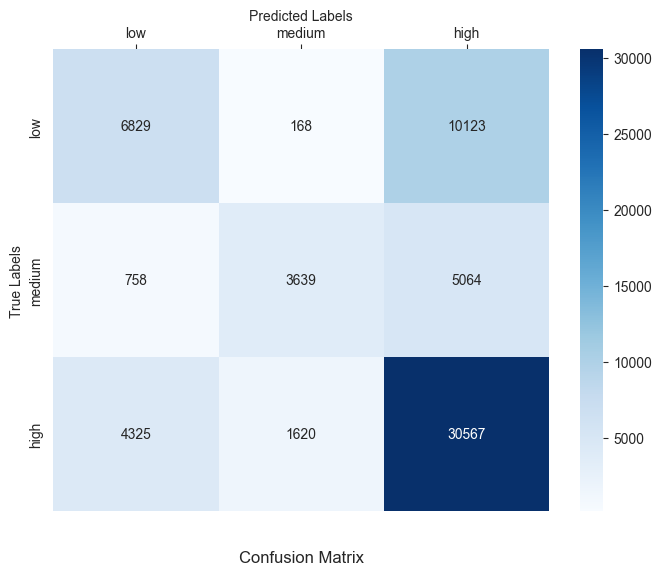

In [54]:
# 构建混淆矩阵
conf_matrix = confusion_matrix(y_test_labels, pred_labels)

# 使用Seaborn可视化混淆矩阵
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# 将 x 轴标签置于图像上方
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.text(0.5, -0.1, 'Confusion Matrix', fontsize=12, ha='center', va='center', transform=ax.transAxes)
plt.show()

In [55]:
# 总体 Accuracy 计算
total_accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
print(f"总体 Accuracy: {total_accuracy:.2f}")

# 每个类别的 Accuracy 计算
class_accuracy = np.diag(conf_matrix) / conf_matrix.sum(axis=1)
print("每个类别的 Accuracy:")
for idx, acc in enumerate(class_accuracy):
    print(f"{idx}: {acc:.2f}")

总体 Accuracy: 0.65
每个类别的 Accuracy:
0: 0.40
1: 0.38
2: 0.84
